In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, io, morphology, segmentation
from skimage.color import rgb2gray
from skimage.measure import label, regionprops


def open_image(fname):
    return io.imread(fname)


def image_segmentation(img):
    gray = rgb2gray(img)
    mask = gray > filters.threshold_otsu(gray)
    borders = segmentation.clear_border(mask).astype(np.int64)
    segmentation.mark_boundaries(gray, borders)
    label_img = label(borders)
    regions = regionprops(label_img)
    return mask, borders, regions


def find_pellet(regions):
    area = 0
    for region in regions:
        if region.area > area:
            area = region.area
            pellet = region
    return pellet


def mask_background(mask, pellet):
    threshold = pellet.area * 0.01
    return morphology.remove_small_objects(mask, pellet.area - threshold)


def show_masked(img, borders, maskr):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 8))

    masked = img.copy()
    masked[~maskr] = 255
    ax0.imshow(masked)
    ax1.imshow(img)
    ax1.contour(borders, [0.5], colors="r")

    from glob import glob


from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io


def get_dominant_color(pil_img, palette_size=16):
    # Resize image to speed up processing
    img = pil_img.copy()
    img.thumbnail((100, 100))

    # Reduce colors (uses k-means internally)
    paletted = img.convert("P", palette=Image.Palette.ADAPTIVE, colors=palette_size)

    # Find the color that occurs most often
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    idx = 1  # We want the second one to avoid getting the mask, otherwise use 0.
    palette_index = color_counts[idx][
        1
    ]  # We want the second one to avoid getting the mask
    dominant_color = palette[palette_index * 3 : palette_index * 3 + 3]

    return dominant_color

# The dataset

In [2]:
fname = Path("cl1_p11_moca2_deixa5_a0001.jpg")
img = open_image(fname)


mask, borders, regions = image_segmentation(img)
area = find_pellet(regions)

maskr = mask_background(mask, area)

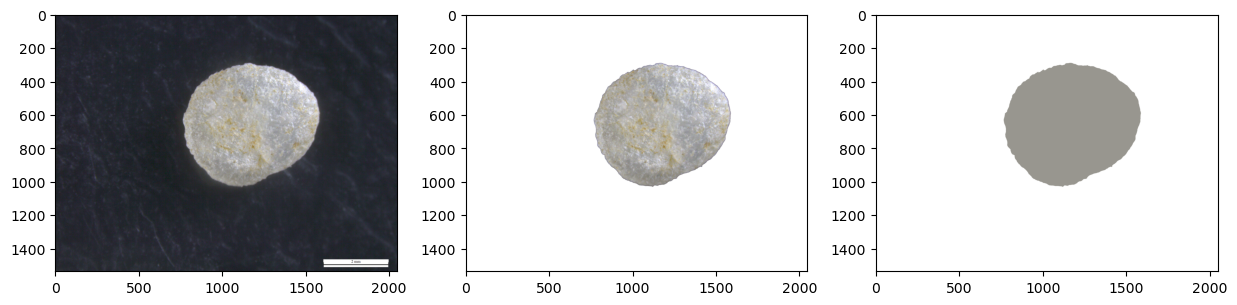

In [3]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))

ax0.imshow(img)

# Remove background
img[~maskr] = 255
ax1.imshow(img)

# Dominant color
pil_img = Image.fromarray(img)
R, G, B = get_dominant_color(pil_img)

colored = img.copy()
colored[maskr, 0], colored[maskr, 1], colored[maskr, 2] = R, G, B
ax2.imshow(colored);